<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Time-Series-Models" data-toc-modified-id="Time-Series-Models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Time Series Models</a></span><ul class="toc-item"><li><span><a href="#Chicago-Gun-Data" data-toc-modified-id="Chicago-Gun-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Chicago Gun Data</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#The-Autoregressive-Model-(AR)" data-toc-modified-id="The-Autoregressive-Model-(AR)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>The Autoregressive Model (AR)</a></span><ul class="toc-item"><li><span><a href="#statsmodels.tsa.arima_model.ARIMA" data-toc-modified-id="statsmodels.tsa.arima_model.ARIMA-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span><code>statsmodels.tsa.arima_model.ARIMA</code></a></span></li></ul></li><li><span><a href="#Moving-Average-Model-(MA)" data-toc-modified-id="Moving-Average-Model-(MA)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Moving Average Model (MA)</a></span></li><li><span><a href="#ARMA" data-toc-modified-id="ARMA-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>ARMA</a></span></li></ul></li><li><span><a href="#LEVEL-UPS" data-toc-modified-id="LEVEL-UPS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LEVEL UPS</a></span><ul class="toc-item"><li><span><a href="#ACF-and-PACF" data-toc-modified-id="ACF-and-PACF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>ACF and PACF</a></span><ul class="toc-item"><li><span><a href="#PACF" data-toc-modified-id="PACF-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>PACF</a></span></li><li><span><a href="#ACF" data-toc-modified-id="ACF-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>ACF</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#SARIMA" data-toc-modified-id="SARIMA-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>SARIMA</a></span></li><li><span><a href="#Forecast" data-toc-modified-id="Forecast-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Forecast</a></span></li></ul></li></ul></div>

# Learning Goals

- Build time-series models with `statsmodels`
- Cross-validate time-series models

# Time Series Models

In [1]:
# a lot of new imports.  e.g. very specific timeseriessplit, ARIMA

from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

import itertools
#from pmdarima import auto_arima - kind of like a randomized GridSearch?

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


%matplotlib inline

## Chicago Gun Data

Let's reimport our chicago gun crime data, and prepare it in the same manner as the last notebook.


In [2]:
# read in
ts = pd.read_csv('data/Gun_Crimes_Heat_Map.csv')
# date time
ts['Date'] = pd.to_datetime(ts.Date)
# group by
ts_minute = ts.groupby('Date').count()['ID']
# resample
daily_count = ts_minute.resample('D').sum()
# looking for daily count <90
daily_count = daily_count[daily_count < 90]

# setting index
ts_dr = pd.date_range(daily_count.index[0], daily_count.index[-1])
ts_daily = np.empty(shape=len(ts_dr))
ts_daily = pd.Series(ts_daily)
ts_daily = ts_daily.reindex(ts_dr)
ts_daily = ts_daily.fillna(daily_count)
ts_daily = ts_daily.interpolate()

# getting a weekly average
ts_weekly = ts_daily.resample('W').mean()

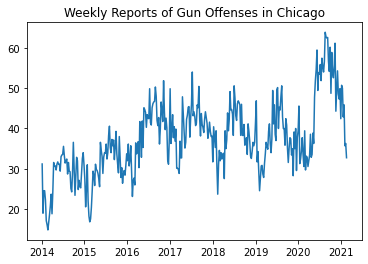

In [3]:
fig, ax = plt.subplots()
ax.plot(ts_weekly)
ax.set_title("Weekly Reports of Gun Offenses in Chicago");

The train-test split for a time series is a little different from what we are used to. Because **chronological order matters**, we cannot randomly sample points in our data. Instead, we cut off a portion of our data at the end, and reserve it as our test set.

In [4]:
ts_weekly.shape[0] * 0.8

297.6

In [5]:
# find the index which allows us to split off 20% of the data
cutoff = round(ts_weekly.shape[0]*0.8)
cutoff

298

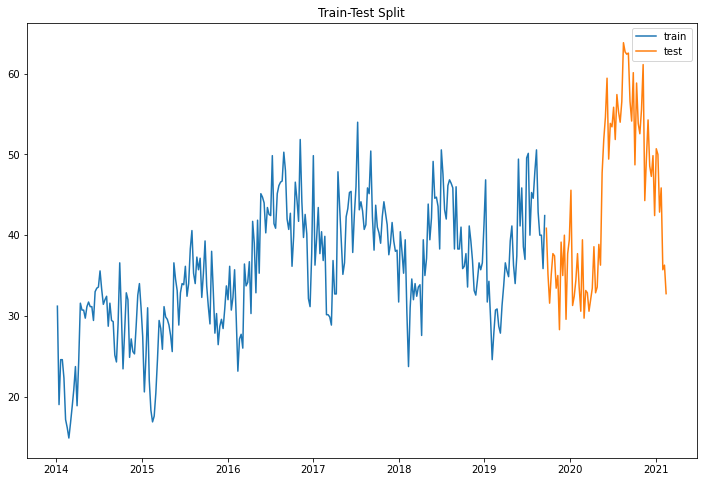

In [6]:
# Define train and test sets according to the index found above
train = ts_weekly[:cutoff]

test = ts_weekly[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

# so this is a manual train-test split at 80%
# AKA fixed partitioning

### `sklearn.model_selection.TimeSeriesSplit`

Let's also use `sklearn`'s in-built class to prepare our model for a kind of cross-validation:

In [7]:
split = TimeSeriesSplit()

# actually provides us indices to split on at fixed time intervals

We will now set aside our test set, and build our model on the train.

## Baseline

In [8]:
train

2014-01-05    31.200000
2014-01-12    19.000000
2014-01-19    24.571429
2014-01-26    24.571429
2014-02-02    22.285714
                ...    
2019-08-18    42.857143
2019-08-25    40.000000
2019-09-01    40.000000
2019-09-08    35.857143
2019-09-15    42.428571
Freq: W-SUN, Length: 298, dtype: float64

In [9]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
naive = train.shift(1)
naive

2014-01-05          NaN
2014-01-12    31.200000
2014-01-19    19.000000
2014-01-26    24.571429
2014-02-02    24.571429
                ...    
2019-08-18    50.571429
2019-08-25    42.857143
2019-09-01    40.000000
2019-09-08    40.000000
2019-09-15    35.857143
Freq: W-SUN, Length: 298, dtype: float64

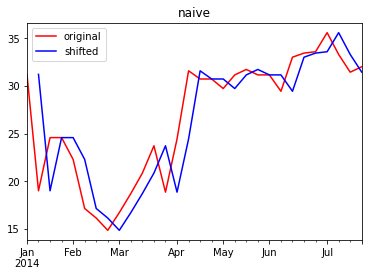

In [10]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

For a baseline to compare our later models, lets calculate our **RMSE** for the naive model.

In [11]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

# feeding in training values minus the first value (which is NaN)
# this is an error of 4.8 gun offenses

4.774206044857893

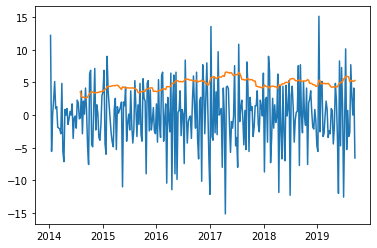

In [12]:
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]  # naive minus actuals
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

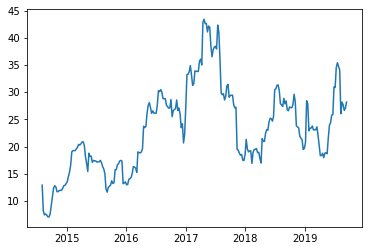

In [13]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

# the naive model varies greatly over time.  Not picking up on any trends with
# that naive model

If we look at the rolling standard deviation of our errors, we can see that the performance of our model varies at different points in time.

That is a result of the trends in our data.

In the previous notebook, we were able to make our series **stationary** by differencing our data.

Visually, our differenced data looks *more* like white noise:

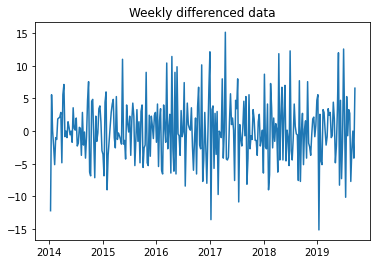

In [14]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

By removing the trend from our data, we assume that our data's mean and variance are constant throughout.  But it is **not** just white noise.  If it were, our models could do no better than random predictions around the mean.  

Our task now is to find **more patterns** in the series.  

We will focus on the data points near to the point in question.  We can attempt to find patterns to how much influence previous points in the sequence have. 

If that made you think of regression, great! What we will be doing is assigning weights, like our betas, to previous points.

Let's make sure our data after differencing is stationary:

In [15]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")
    
    
# this proves it's stationary with a statistical test now

# now we can start modeling.  And we have a naive model to compare it too

The p-value associated with the Dickey-Fuller statistical test is 4.989352226039392e-24,
 so we can safely assume that the differenced data is stationary.


## The Autoregressive Model (AR)

### `statsmodels.tsa.arima_model.ARIMA`

This model is really a compound of two simpler models. This ARIMA class takes a triple of values as its "order". We'll explain this shortly, but for now just note that the first member of the triple, i.e. the **p** variable of the order (p, d, q), represents the AR term. So for a first-order AR model, we'll put a 1 there.

The 1 in the second place of the order will do our differencing for us.

In [16]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()  #instantiate, giving endog - train,
# also p, d, q terms.  p=AR, d = differencing term, q= MA
# the d is what makes ARMA into ARIMA

# can give data in the instantiation, and .fit().  
# The statsmodels convention (like OLS), different than sklearn

# We put a type='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

# talked about type='linear' (default) - would predict the amount of differencing
# type='levels' - undoes that transformation, and back into units of endog

2014-01-05     0.000000
2014-01-12    31.199795
2014-01-19    22.517714
2014-01-26    22.964978
2014-02-02    24.571429
                ...    
2019-08-18    49.788799
2019-08-25    45.081459
2019-09-01    40.823821
2019-09-08    40.000000
2019-09-15    37.051683
Freq: W-SUN, Name: predicted_mean, Length: 298, dtype: float64

The ARIMA class comes with a nice summary table.  

In [17]:
ar_1.summary()

# nice - just like with linear regression (this is AUTO regression)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -873.148
Date:                Wed, 23 Nov 2022   AIC                           1750.296
Time:                        15:53:29   BIC                           1757.683
Sample:                    01-05-2014   HQIC                          1753.253
                         - 09-15-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2883      0.056     -5.184      0.000      -0.397      -0.179
sigma2        20.9389      1.554     13.478      0.000      17.894      23.984
===================================================================================
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):                 5.01
Prob(Q):                              0.15   Prob(JB):                         0.08
Heteroskedasticity (H):               1.42   Skew:                             0.23
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
ar_1.aic

1750.295516508531

### Sidebar: Akaike Information Criterion

But, as you may notice, the output does not include RMSE.

It does include [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion). A better model has a **lower** AIC.

Let's compare the first order autoregressive model to our Random Walk.

In [19]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

# higher AIC, not as good

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -885.703
Date:                Wed, 23 Nov 2022   AIC                           1773.407
Time:                        15:55:11   BIC                           1777.100
Sample:                    01-05-2014   HQIC                          1774.885
                         - 09-15-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        22.7930      1.677     13.589      0.000      19.506      26.080
===================================================================================
Ljung-Box (L1) (Q):                  23.73   Jarque-Bera (JB):                 3.70
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               1.61   Skew:                             0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

# AR of 1 is not doing as good as naive model

Random Walk AIC: 1773.4067346708443
AR(1, 1, 0) AIC: 1750.295516508531


Our AIC for the AR(1) model is lower than the random walk, indicating improvement.  

Let's also check the RMSE.

In [21]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

4.916994704905525

In [22]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

5.097365380006156

RMSE is lower as well.

### Cross-Validation

For this it will help to have our normal integer index.

In [ ]:
# UNDOING DateTime as index

In [23]:
train.index

DatetimeIndex(['2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26',
               '2014-02-02', '2014-02-09', '2014-02-16', '2014-02-23',
               '2014-03-02', '2014-03-09',
               ...
               '2019-07-14', '2019-07-21', '2019-07-28', '2019-08-04',
               '2019-08-11', '2019-08-18', '2019-08-25', '2019-09-01',
               '2019-09-08', '2019-09-15'],
              dtype='datetime64[ns]', length=298, freq='W-SUN')

In [25]:
train_with_ind = train.reset_index()
train_with_ind

# still keeping dates, but index back to 0

,index,0
0,2014-01-05,31.200000
1,2014-01-12,19.000000
2,2014-01-19,24.571429
3,2014-01-26,24.571429
4,2014-02-02,22.285714
...,...,...
293,2019-08-18,42.857143
294,2019-08-25,40.000000
295,2019-09-01,40.000000
296,2019-09-08,35.857143


In [26]:
# finally using split instantiated higher up

for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 0)).fit()
    
    # giving start and end points for predictions 
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))
    
    # defaults to 5 folds

6.297322824877591
12.525959229326649
5.555339161743894
7.320104431946354
6.469898485828603


### Comparison with `sklearn.linear_model.LinearRegression`

Autoregression, as we said before, is a regression of a time series on lagged values of itself.  

From the summary, we see the coefficient of the 1st lag:

In [27]:
ar_1.arparams

# our coef

array([-0.28833722])

We come close to reproducing this coefficient with linear regression, with slight differences due to how statsmodels performs the regression. 

In [28]:
lr = LinearRegression()
# fit to our X, and regress on our shift
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1, 1), train[1:].diff().dropna())
print(lr.coef_)

# pretty close

[-0.28299508]


### Adding a Term

We can also factor in more than just the most recent point.
$$\large y_{t} = \phi_{0} + \phi_{1}y_{t-1} + \phi_{2}y_{t-2}+ \varepsilon_{t}$$

We refer to the order of our AR model by the number of lags back we go.  The above formula refers to an **AR(2)** model. We put a 2 in the p position of the ARIMA class order.

In [29]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()  # changing AR model

ar_2.predict(typ='levels')

2014-01-05     0.000000
2014-01-12    31.199797
2014-01-19    22.481150
2014-01-26    26.323162
2014-02-02    22.816761
                ...    
2019-08-18    48.518157
2019-08-25    44.896897
2019-09-01    43.501611
2019-09-08    40.899830
2019-09-15    37.411646
Freq: W-SUN, Name: predicted_mean, Length: 298, dtype: float64

In [30]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

1773.4067346708443
1750.295516508531
1722.0181960795057


In [31]:
y_hat_ar1 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

4.710330730740042

Our AIC improves with more lagged terms.

In [32]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

5.735878351613108
12.479028371281457
6.188886635266759
6.741524262748229
6.286222565093472


This is better on four out of five validation tests compared to the one-term model.

## Moving Average Model (MA)

The next type of model is based on error.  The idea behind the moving average model is to make a prediction based on how far off we were the day before.

$$\large Y_t = \mu +\epsilon_t + \theta\epsilon_{t-1}$$

The moving average model works like this. We make a prediction, see how far off we were, then adjust our next prediction by a factor of how far off our pervious prediction was.

In our ARIMA model, the q term of our order (p, d, q) refers to the MA component. To use one lagged error, we put 1 in the q position.

In [33]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

2014-01-05    35.658933
2014-01-12    33.580932
2014-01-19    26.978507
2014-01-26    34.106432
2014-02-02    29.305679
                ...    
2019-08-18    40.795779
2019-08-25    37.069285
2019-09-01    37.664081
2019-09-08    37.257131
2019-09-15    34.701084
Freq: W-SUN, Name: predicted_mean, Length: 298, dtype: float64

In [34]:
ma_1.summary()

# pretty bad, not stationary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -936.689
Date:                Wed, 23 Nov 2022   AIC                           1879.379
Time:                        16:03:38   BIC                           1890.470
Sample:                    01-05-2014   HQIC                          1883.819
                         - 09-15-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.6589      0.560     63.726      0.000      34.562      36.756
ma.L1          0.6842      0.045     15.182      0.000       0.596       0.773
sigma2        31.3906      2.702     11.620      0.000      26.096      36.685
===================================================================================
Ljung-Box (L1) (Q):                  24.44   Jarque-Bera (JB):                 1.50
Prob(Q):                              0.00   Prob(JB):                         0.47
Heteroskedasticity (H):               0.84   Skew:                             0.15
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's look at the 1st order MA model with a 1st order difference

In [35]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

1773.4067346708443
1750.295516508531
1722.0181960795057
1724.1691361580697


In [36]:
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

4.740463782120451

It performs better than our AR(1) model and comparably to our AR(2) model.

In [37]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

5.917798941099929
12.406853551173475
6.039059627294341
6.640959387780795
6.254637050206334


Just like our AR models, we can lag back as far as we want. Our MA(2) model would use the past two lagged terms:

$$\large Y_t = \mu +\epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2}$$

and our MA term would be two.

In [38]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit() # now MA is 2
y_hat = ma_2.predict(typ='levels')
y_hat

2014-01-05     0.000000
2014-01-12    31.199814
2014-01-19    22.258189
2014-01-26    25.849647
2014-02-02    24.629101
                ...    
2019-08-18    48.131076
2019-08-25    44.144699
2019-09-01    42.741324
2019-09-08    41.946282
2019-09-15    38.868990
Freq: W-SUN, Name: predicted_mean, Length: 298, dtype: float64

In [39]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

1773.4067346708443
1750.295516508531
1722.0181960795057
1724.1691361580697
1716.961348764834


In [40]:
y_hat_ar1 = ma_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

4.676009620926742

In [41]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

5.7758562702747565
12.178475239525422
6.19550880496333
6.531439207091588
6.2455163931546345


In [ ]:
# now let's take the best of both and include and AR and an MA term

## ARMA

We don't have to limit ourselves to just AR or MA.  We can use both AR terms and MA terms.

for example, an ARMA(2, 2) model is given by:

 $$\large Y_t = \mu+\phi_1 Y_{t-1}+\phi_2 Y_{t-2}+\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}+\epsilon_t$$

In [42]:
arma_22 = ARIMA(train, order=(2, 1, 2)).fit()

In [43]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_22.aic)

# even a little better still

1773.4067346708443
1750.295516508531
1722.0181960795057
1724.1691361580697
1716.961348764834
1715.9771245191587


In [44]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [46]:
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_22))

# error is getting better (lower)

5.097365380006156
4.916994704905525
4.710330730740042
4.740463782120451
4.676009620926742
4.6442651991061625


In [47]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

5.676392344788754
13.119465373271401
6.343356445829016
6.5036344178113605
6.233575972461558


In [48]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [49]:
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_22))

10.527048559730781
10.884018936739286
11.023282807447027
11.012718704542811
10.7293441979943
10.834906689162002


# LEVEL UPS

## ACF and PACF

We have been able to reduce our AIC by chance, adding fairly random p, d, and q terms.

But we have tools to help guide us in these decisions: the autocorrelation and partial autocorrelation functions.

### PACF

In general, a partial correlation is a **conditional correlation**. It is the  amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags. If $Y_t$ is correlated with $Y_{t-1}$, and $Y_{t-1}$ is equally correlated with $Y_{t-2}$, then we should also expect to find correlation between $Y_t$ and $Y_{t-2}$. Thus, the correlation at lag 1 "propagates" to lag 2 and presumably to higher-order lags. The partial autocorrelation at lag 2 is therefore the difference between the actual correlation at lag 2 and the expected correlation due to the propagation of correlation at lag 1.

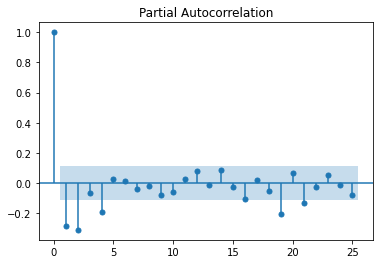

In [50]:
plot_pacf(train.diff().dropna());

The shaded area of the graph is the confidence interval. When the correlation drops into the shaded area, that means there is no longer statistically significant correlation between lags.

In [ ]:
# so points OUTSIDE the shaded area ARE statistically significant

For an AR process, we run a linear regression on lags according to the order of the AR process. The coefficients calculated factor in the influence of the other variables.   

Since the PACF shows the direct effect of previous lags, it helps us choose AR terms.  If there is a significant positive value at a lag, consider adding an AR term according to the number that you see.

In [ ]:
# so in the above plot...?  2 maybe?

**Some rules of thumb:**

    - A sharp drop after lag "k" suggests an AR-k model.
    - A gradual decline suggests an MA.

### ACF

The autocorrelation plot of our time series is simply a version of the correlation plots we used in linear regression.  Our features this time are prior points in the time series, or the **lags**. 

We can calculate a specific covariance ($\gamma_k$) with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y_t})(y_{t+k}-\bar{y_{t+k}})}$

In [51]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df.head()

# looking at the shift again

,lag_0,lag_1
2014-01-05,31.200000,NaN
2014-01-12,19.000000,31.200000
2014-01-19,24.571429,19.000000
2014-01-26,24.571429,24.571429
2014-02-02,22.285714,24.571429


In [52]:
gamma_1 = sum(((df['lag_0'][1:]-df['lag_0'][1:].mean()) *\
               (df['lag_1'].dropna()-df['lag_1'].dropna().mean())))/(len(df['lag_1'])-1)
gamma_1

46.958988265577986

We then compute the Pearson correlation:

$\large\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

In [53]:
rho = gamma_1/(df.lag_0[1:].std(ddof=0)*df.lag_1.std(ddof=0))
rho

0.8047153950801794

In [54]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df['lag_2'] = train.shift(2)
df['lag_3'] = train.shift(3)
df['lag_4'] = train.shift(4)
df['lag_5'] = train.shift(5)
df.corr()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
lag_0,1.000000,0.804715,0.722625,0.717688,0.669491,0.666226
lag_1,0.804715,1.000000,0.805692,0.722265,0.717315,0.668552
lag_2,0.722625,0.805692,1.000000,0.806084,0.722627,0.718362
lag_3,0.717688,0.722265,0.806084,1.000000,0.805867,0.722296
lag_4,0.669491,0.717315,0.722627,0.805867,1.000000,0.805702
lag_5,0.666226,0.668552,0.718362,0.722296,0.805702,1.000000


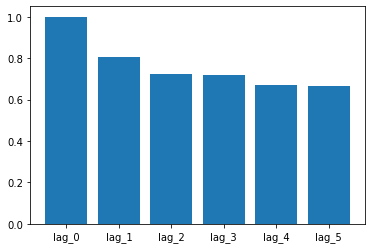

In [55]:
list(df.corr()['lag_0'].index)
plt.bar(list(df.corr()['lag_0'].index), list(df.corr()['lag_0']));

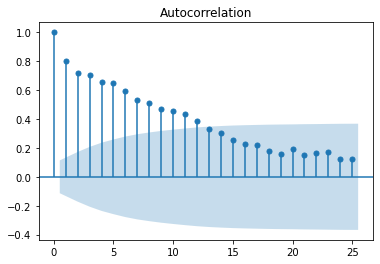

In [56]:
# Original data with plot ACF

plot_acf(train);

# correlation with lag of 12 weeks?

# this is very autocorrelated, and therefore not stationary

The above autocorrelation shows that there is correlation between lags up to about 12 weeks back.  

When Looking at the ACF graph for the original data, we see a strong persistent correlation with higher order lags. This is evidence that we should take a **first difference** of the data to remove this autocorrelation.

This makes sense, since we are trying to capture the effect of recent lags in our ARMA models, and with high correlation between distant lags, our models will not come close to the true process.

Generally, we use an ACF to predict MA terms.
Moving Average models are using the error terms of the predictions to calculate the next value.  This means that the algorithm does not incorporate the direct effect of the previous value. It models what are sometimes called **impulses** or **shocks** whose effect accounts for the propogation of correlation from one lag to the other. 

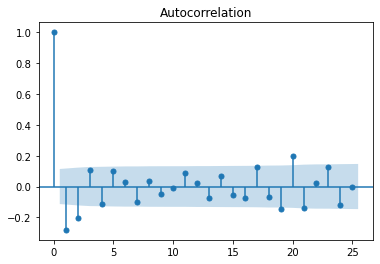

In [57]:
plot_acf(train.diff().dropna());

# different than plot_pacf

In [ ]:
# end result...

This autocorrelation plot can now be used to get an idea of a potential MA term.  Our differenced series shows negative significant correlation at a lag of 1, which suggests adding 1 MA term. There is also a statistically significant 2nd term, so adding another MA is another possibility.


> If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms. [Duke](https://people.duke.edu/~rnau/411arim3.htm#signatures)

**Rule of thumb:**
    
  - If the autocorrelation shows negative correlation at the first lag, try adding MA terms.
    
    

![alt text](images/armaguidelines.png)

The plots above suggest that we should try a 1st order differenced MA(1) or MA(2) model on our weekly gun offense data.

This aligns with our AIC scores from above.

The ACF can be used to identify the possible structure of time series data. That can be tricky going forward as there often isn’t a single clear-cut interpretation of a sample autocorrelation function.

Let's plot our training predictions, using an ARIMA model with order (1, 1, 2).

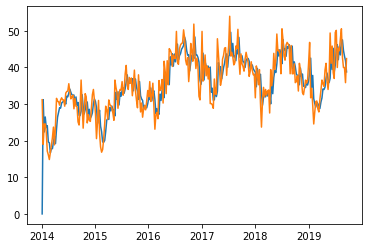

In [58]:
aa_model = ARIMA(train, order=(1, 1, 2)).fit()  # so settled on 1, 1, 2
y_hat_train = aa_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

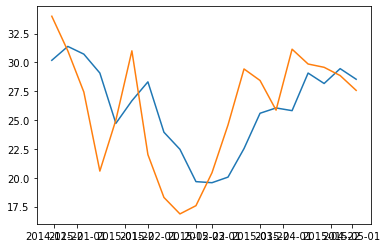

In [59]:
# Let's zoom in:

fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70]);

In [60]:
aa_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -853.009
Date:                Wed, 23 Nov 2022   AIC                           1714.019
Time:                        16:18:55   BIC                           1728.794
Sample:                    01-05-2014   HQIC                          1719.934
                         - 09-15-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4760      0.169     -2.816      0.005      -0.807      -0.145
ma.L1          0.0678      0.160      0.425      0.671      -0.245       0.380
ma.L2         -0.4418      0.081     -5.436      0.000      -0.601      -0.283
sigma2        18.2629      1.370     13.329      0.000      15.577      20.948
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.12
Prob(Q):                              0.98   Prob(JB):                         0.08
Heteroskedasticity (H):               1.39   Skew:                             0.24
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Testing

Now that we have chosen our parameters, let's try our model on the test set.

In [61]:
test

2019-09-22    40.857143
2019-09-29    35.142857
2019-10-06    31.571429
2019-10-13    35.142857
2019-10-20    37.714286
                ...    
2021-01-17    42.857143
2021-01-24    45.857143
2021-01-31    35.714286
2021-02-07    36.285714
2021-02-14    32.750000
Freq: W-SUN, Length: 74, dtype: float64

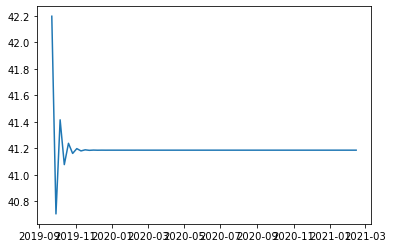

In [62]:
y_hat_test = aa_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_test);

# predictions... not great

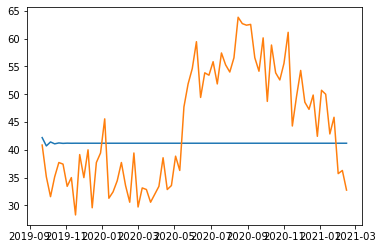

In [63]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test);

# plot against the actual...

In [64]:
np.sqrt(mean_squared_error(test, y_hat_test))

# error of 10.8 now!

10.815604029696797

Our predictions on the test set certainly leave something to be desired.  

Let's take another look at our autocorrelation function of the original series.

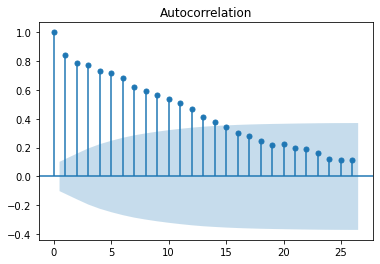

In [65]:
plot_acf(ts_weekly);

Let's increase the lags

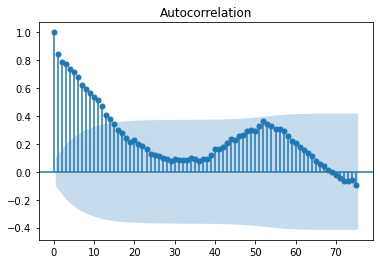

In [66]:
plot_acf(ts_weekly, lags=75);

There seems to be a wave of correlation at around 50 lags.
What is going on?

In [ ]:
# pretty indicative of a seasonal pattern.  
# noticed that apparent seasonal pattern in original plot
# Maybe we decompose?
# 52 lags = 52 weeks = 1 year.  Pretty clear...

## SARIMA

Looks like we may have some other forms of seasonality.  Luckily, we have SARIMA, which stands for Seasonal Auto Regressive Integrated Moving Average.  That is a lot.  The `statsmodels` package is actually called SARIMAX.  The X stands for exogenous, and we are only dealing with endogenous variables, but we can use this class.

A seasonal ARIMA model is classified as an **ARIMA(p,d,q)x(P,D,Q)** model, 

    **p** = number of autoregressive (AR) terms 
    **d** = number of differences 
    **q** = number of moving average (MA) terms
     
    **P** = number of seasonal autoregressive (SAR) terms 
    **D** = number of seasonal differences 
    **Q** = number of seasonal moving average (SMA) terms

I.e. P and Q specify the number of seasons to include.

In [67]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))
        
# 52 is the lags

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 1, 0, 52)
SARIMAX: (0, 1, 0) x (1, 1, 1, 52)
SARIMAX: (0, 1, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 1) x (0, 1, 1, 52)
SARIMAX: (0, 1, 1) x (1, 1, 0, 52)
SARIMAX: (0, 1, 1) x (1, 1, 1, 52)
SARIMAX: (1, 1, 0) x (0, 1, 0, 52)
SARIMAX: (1, 1, 0) x (0, 1, 1, 52)
SARIMAX: (1, 1, 0) x (1, 1, 0, 52)
SARIMAX: (1, 1, 0) x (1, 1, 1, 52)
SARIMAX: (1, 1, 1) x (0, 1, 0, 52)
SARIMAX: (1, 1, 1) x (0, 1, 1, 52)
SARIMAX: (1, 1, 1) x (1, 1, 0, 52)
SARIMAX: (1, 1, 1) x (1, 1, 1, 52)


In [68]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue
            
# this takes a while 

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:1576.87882914831
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:1204.4985892675745
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:1225.469705290875
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:1207.669961136548
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:1481.7587656853211
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:1129.1627382653683
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:1160.7640473650872
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:1134.734239043732
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:1535.5697927084516
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:1180.5485531144532
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:1189.3533353019384
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:1182.965587327094
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:1476.6008134793076
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:1124.4148822782001
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:1144.5347878580533
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:1129.8052126359516


Let's try the third from the bottom, ARIMA(1, 1, 1)x(0, 1, 1, 52).

In [ ]:
# AIC is 1124, the best

In [69]:
sari_mod =SARIMAX(train,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

# training data, then order, then seasonal order.  The order and seasonal order
# do not have to match
# don't want to enforce_stationarity because we're already differencing

In [70]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(1, 1, 1),
                      seasonal_order=(0, 1, 1, 52),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))
    
# errors for small amounts of data in initial rolling split

C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


7.574548012434134


C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


12.036675604253983


C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


8.972366690606199


C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


5.155123816384316


C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4.793508089261537


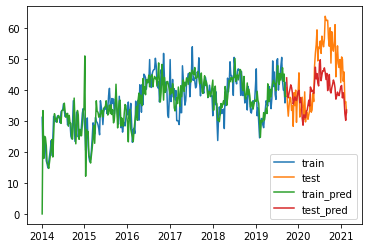

In [71]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

# seasonal (SARIMA) looking much better than the "best" ARIMA

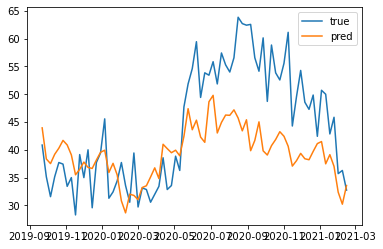

In [72]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [73]:
np.sqrt(mean_squared_error(test, y_hat_test))

# still not as good as the naive model but better than ARIMA

9.233681913750958

## Forecast

Lastly, let's predict into the future.

To do so, we'll refit to our entire training set.

In [74]:
# refit to FULL dataset

sari_mod = SARIMAX(ts_weekly,
                   order=(1, 1, 1),
                   seasonal_order=(0, 1, 1, 52),
                   enforce_stationarity=False,
                   enforce_invertibility=False).fit()

In [75]:
forecast = sari_mod.forecast(steps=52)

# can give variety of info for 'steps', e.g. datetime

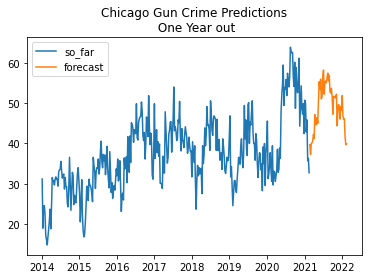

In [76]:
fig, ax = plt.subplots()
ax.plot(ts_weekly, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Chicago Gun Crime Predictions\n One Year out')

plt.legend();

In [77]:
forecast
# will give estimates by weeks into the future

2021-02-21    39.696031
2021-02-28    37.286288
2021-03-07    39.989925
2021-03-14    40.142617
2021-03-21    40.621815
2021-03-28    42.226060
2021-04-04    41.253092
2021-04-11    47.145883
2021-04-18    44.977214
2021-04-25    44.595429
2021-05-02    46.410458
2021-05-09    45.026962
2021-05-16    50.690545
2021-05-23    55.319358
2021-05-30    53.377296
2021-06-06    55.935826
2021-06-13    51.045848
2021-06-20    51.601090
2021-06-27    56.670351
2021-07-04    58.181460
2021-07-11    52.228712
2021-07-18    55.109069
2021-07-25    55.501519
2021-08-01    55.057038
2021-08-08    56.464601
2021-08-15    57.460614
2021-08-22    55.514327
2021-08-29    56.848005
2021-09-05    52.859614
2021-09-12    52.529935
2021-09-19    53.691193
2021-09-26    51.518776
2021-10-03    47.261736
2021-10-10    51.660285
2021-10-17    51.443058
2021-10-24    51.709848
2021-10-31    51.274445
2021-11-07    52.206465
2021-11-14    44.356884
2021-11-21    48.538557
2021-11-28    49.665144
2021-12-05    48